In [1]:
     # ========== STANDARD LIBRARIES ==========
import os
import time
import numpy as np
import pandas as pd

# ========== VISUALIZATION ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== SCIKIT-LEARN (Machine Learning) ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# ========== TENSORFLOW / KERAS (Deep Learning) ==========
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Flatten,
    Bidirectional, LSTM, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    CSVLogger, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

2025-11-20 02:27:25.147681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763605645.340025      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763605645.401781      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
from cpuinfo import get_cpu_info

cpu_info = get_cpu_info()
print("CPU Hardware on Kaggle")
print(f"Brand: {cpu_info['brand_raw']}")
print(f"Architecture: {cpu_info['arch']}")
print(f"Cores (Physical): {cpu_info['count']}")
print(f"Threads (Logical): {cpu_info['count'] * 2 if 'ht' in cpu_info['flags'] else cpu_info['count']}")
print(f"Clock Speed: {cpu_info['hz_advertised_friendly']}")
print(f"Flags (Features): {cpu_info['flags'][:10]}...")  # Shows first 10 CPU features

CPU Hardware on Kaggle
Brand: Intel(R) Xeon(R) CPU @ 2.00GHz
Architecture: X86_64
Cores (Physical): 4
Threads (Logical): 8
Clock Speed: 2.0000 GHz
Flags (Features): ['3dnowprefetch', 'abm', 'adx', 'aes', 'apic', 'arat', 'arch_capabilities', 'avx', 'avx2', 'avx512bw']...


In [3]:
# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# check the available data
file_paths = []
for root, dirs, filenames in os.walk('/kaggle/input/ids-intrusion-csv'):
    for filename in filenames:
        file_paths.append(os.path.join(root, filename))
        
# Remove specific file if needed
file_paths.remove('/kaggle/input/ids-intrusion-csv/02-20-2018.csv') # this file is 4.05GB with different shape from the others
print("Number of input files:", len(file_paths))

def load_data(file_paths):
    combined_df = pd.DataFrame()
    for file in file_paths:
        print("Loading:", file)
        data = pd.read_csv(file, low_memory=False)
        
        # Combine with other files
        combined_df = pd.concat([combined_df, data], ignore_index=True, copy=False)

    return combined_df.drop(columns=["Timestamp"]) # remove Timestamp because it's irrelevant to the result
df = load_data(file_paths)
print(df['Label'].value_counts())

target_values = ['DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'Label'] # these targets have too few samples (Label is an error from concatenate data)
df = df[~df['Label'].isin(target_values)]
df = df.groupby('Label', group_keys=False).sample(n=41500, random_state=42)

def clean_data(data):
    encoder = LabelEncoder()
    data['Label'] = encoder.fit_transform(data['Label']) # encode Label (string to number from 0 to 8)
    data = data.apply(pd.to_numeric, errors='coerce') # if error (meet non-numeric value), turn that value into np.nan
    data = data.replace([np.inf, -np.inf], np.nan) # replace inf value (or extreme value) to np.nan
    data = data.dropna()
    return pd.DataFrame(data), encoder
df, encoder = clean_data(df)
df = df.groupby('Label', group_keys=False).sample(n=40000, random_state=42)
# df = pd.DataFrame(df)

print(df['Label'].unique())
print(df['Label'].value_counts())

# Save to output directory
df.to_csv('/kaggle/working/cleaned_data_sampled.csv', index=False)

Number of input files: 9
Loading: /kaggle/input/ids-intrusion-csv/02-28-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/03-01-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-16-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-15-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-21-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/03-02-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-22-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-14-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-23-2018.csv
Label
Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                2

In [5]:
print("Label encoder mapping:")
for i, label in enumerate(encoder.classes_):
    print(f"{i}: {label}")

Label encoder mapping:
0: Benign
1: Bot
2: DDOS attack-HOIC
3: DoS attacks-GoldenEye
4: DoS attacks-Hulk
5: DoS attacks-SlowHTTPTest
6: FTP-BruteForce
7: Infilteration
8: SSH-Bruteforce


In [6]:
def preprocess_and_split(data, test_size=0.2, random_state=42):
    # 1) Tách X, y
    X = data.drop('Label', axis=1)
    y = data['Label']                 # y đã là số nhờ LabelEncoder trước đó

    # 2) Chia train/test trước khi fit selector, scaler (tránh leakage)
    X_train, X_test, y_train_ml, y_test_ml = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 3) Fit selector & scaler trên TRAIN, rồi transform cho cả TRAIN/TEST
    selector = VarianceThreshold(threshold=0.01)
    X_train_filtered = selector.fit_transform(X_train)
    X_test_filtered  = selector.transform(X_test)

    scaler = RobustScaler(quantile_range=(5, 95))
    X_train_ml = scaler.fit_transform(X_train_filtered)
    X_test_ml  = scaler.transform(X_test_filtered)

    # 4) Chuẩn bị nhãn cho CNN (one-hot)
    num_classes = int(y.nunique())        # số lớp toàn cục
    y_train_cnn = to_categorical(y_train_ml, num_classes=num_classes)
    y_test_cnn  = to_categorical(y_test_ml,  num_classes=num_classes)

    # 5) Bản 3D cho CNN/LSTM: (N, n_features, 1)
    X_train_cnn = X_train_ml[..., np.newaxis]
    X_test_cnn  = X_test_ml[...,  np.newaxis]

    return (
        X_train_ml, X_test_ml, y_train_ml, y_test_ml,    # 2D cho scikit-learn
        X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn # 3D + one-hot cho Keras
    )


(
    X_train, X_test, y_train_ml, y_test_ml,      # 2D cho ML models
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn   # 3D cho CNN/LSTM
) = preprocess_and_split(df, test_size=0.2, random_state=42)

print("\nFinal dataset shapes:")
print(f"X_train (ML 2D): {X_train.shape}, y_train_ml: {y_train_ml.shape}")
print(f"X_test  (ML 2D): {X_test.shape},  y_test_ml:  {y_test_ml.shape}")
print(f"X_train_cnn (3D): {X_train_cnn.shape}, y_train_cnn: {y_train_cnn.shape}")
print(f"X_test_cnn  (3D): {X_test_cnn.shape},  y_test_cnn:  {y_test_cnn.shape}")


Final dataset shapes:
X_train (ML 2D): (288000, 67), y_train_ml: (288000,)
X_test  (ML 2D): (72000, 67),  y_test_ml:  (72000,)
X_train_cnn (3D): (288000, 67, 1), y_train_cnn: (288000, 9)
X_test_cnn  (3D): (72000, 67, 1),  y_test_cnn:  (72000, 9)


In [7]:
num_classes = y_train_cnn.shape[1]
timesteps = X_train_cnn.shape[1]  # số feature sau selector/scaler
channels  = X_train_cnn.shape[2]  # = 1

inputs = Input(shape=(timesteps, channels), name="inputs")

# --- CNN feature extractor ---
x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

x = Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

# --- BiLSTM (giữ toàn bộ chuỗi cho Attention) ---
x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm")(x)

# --- Multi-Head Self-Attention ---
attn_out = MultiHeadAttention(num_heads=4, key_dim=64, name="mha")(x, x)
x = x + attn_out                       # residual
x = BatchNormalization()(x)

# --- Pooling theo thời gian (tổng hợp có trọng số sau attention) ---
x = GlobalAveragePooling1D(name="gap")(x)

# --- Classifier head ---
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax', name="softmax")(x)

attn_model = Model(inputs, outputs, name="CNN_BiLSTM_Attn")
attn_model.summary()

I0000 00:00:1763606022.453779      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763606022.455670      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 67, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 67, 128)   │        512 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 67, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 34, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 256)   │     98,560 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 17, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 17, 256)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 17, 256)   │    394,240 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 17, 256)   │    263,168 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 256)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 256)   │      1,024 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 9)         │      1,161 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 793,097 (3.03 MB)

 Trainable params: 791,817 (3.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [8]:
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_cnn))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [9]:
try:
    sample_batch = next(iter(train_dataset))[0]  # Get one batch from training set
    output = cnn_model(sample_batch, training=False)
    print("Sample model output before training:")
    print(output.numpy())
except Exception as e:
    print("Error generating model output before training:", str(e))

Error generating model output before training: name 'cnn_model' is not defined


In [10]:
# Callbacks
lr = 1e-4
optimizer = Adam(learning_rate=lr)
attn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'),
             tf.keras.metrics.Recall(name='Recall')]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    tf.keras.callbacks.TerminateOnNaN()
]


# Training
start_time = time.time()
with tf.device('/GPU:0'):
    print("Training CNN+BiLSTM+Attention...")
    history_attn = attn_model.fit(
        train_dataset,
        epochs=5,
        validation_data=(X_test_cnn, y_test_cnn),
        callbacks=callbacks,
        verbose=1
    )
training_time = time.time()-start_time

print(f"Model trained in {training_time:.2f} seconds")

Training CNN+BiLSTM+Attention...
Epoch 1/5


I0000 00:00:1763606032.323646     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - Precision: 0.6865 - Recall: 0.4446 - accuracy: 0.5785 - loss: 1.3514 - val_Precision: 0.7907 - val_Recall: 0.7676 - val_accuracy: 0.7803 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - Precision: 0.8054 - Recall: 0.7818 - accuracy: 0.7958 - loss: 0.6419 - val_Precision: 0.8449 - val_Recall: 0.8377 - val_accuracy: 0.8396 - val_loss: 0.5408 - learning_rate: 1.0000e-04
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - Precision: 0.8416 - Recall: 0.8330 - accuracy: 0.8380 - loss: 0.4997 - val_Precision: 0.8519 - val_Recall: 0.8464 - val_accuracy: 0.8493 - val_loss: 0.4433 - learning_rate: 1.0000e-04
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - Precision: 0.8505 - Recall: 0.8455 - accuracy: 0.8483 - loss: 0.4197 - val_Precision: 0.8542 - val_Recall: 0.8479 - val_accuracy: 0.8516 - val_loss: 0.3827 - learning_rate: 1.0000e-04
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 43s 3


Evaluating model...
Prediction output shape: (72000, 9)

=== Evaluation Metrics ===
Accuracy : 0.8537 (85.37%)
Precision: 0.8616 (86.16%)
Recall   : 0.8537 (85.37%)
F1-Score : 0.8486 (84.86%)


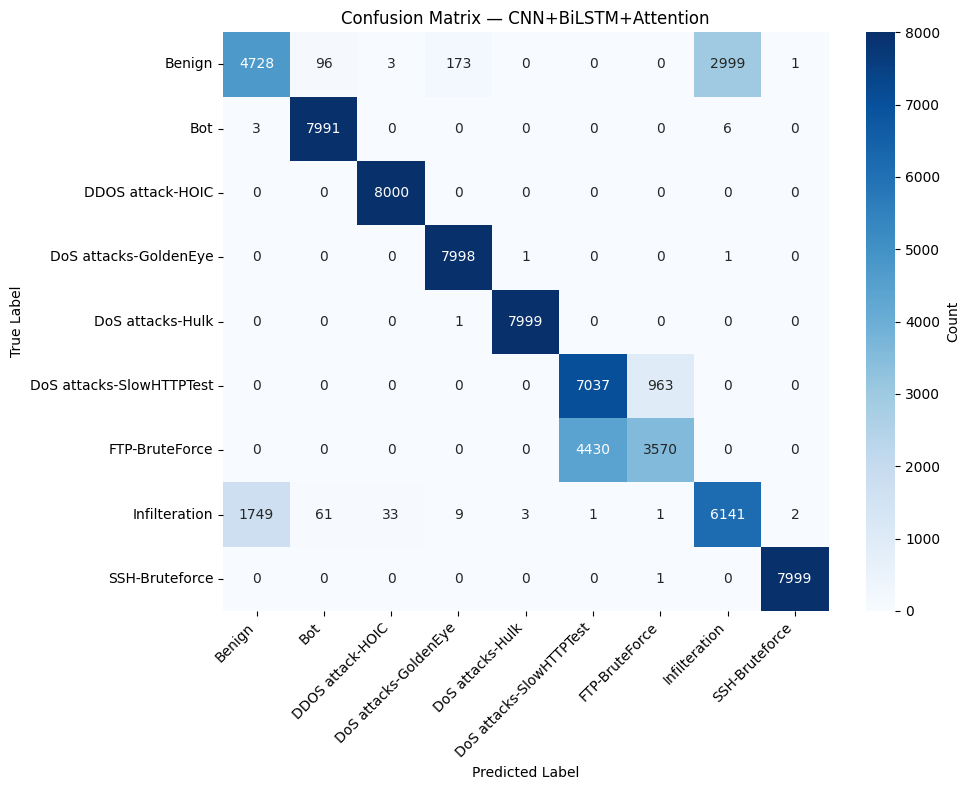

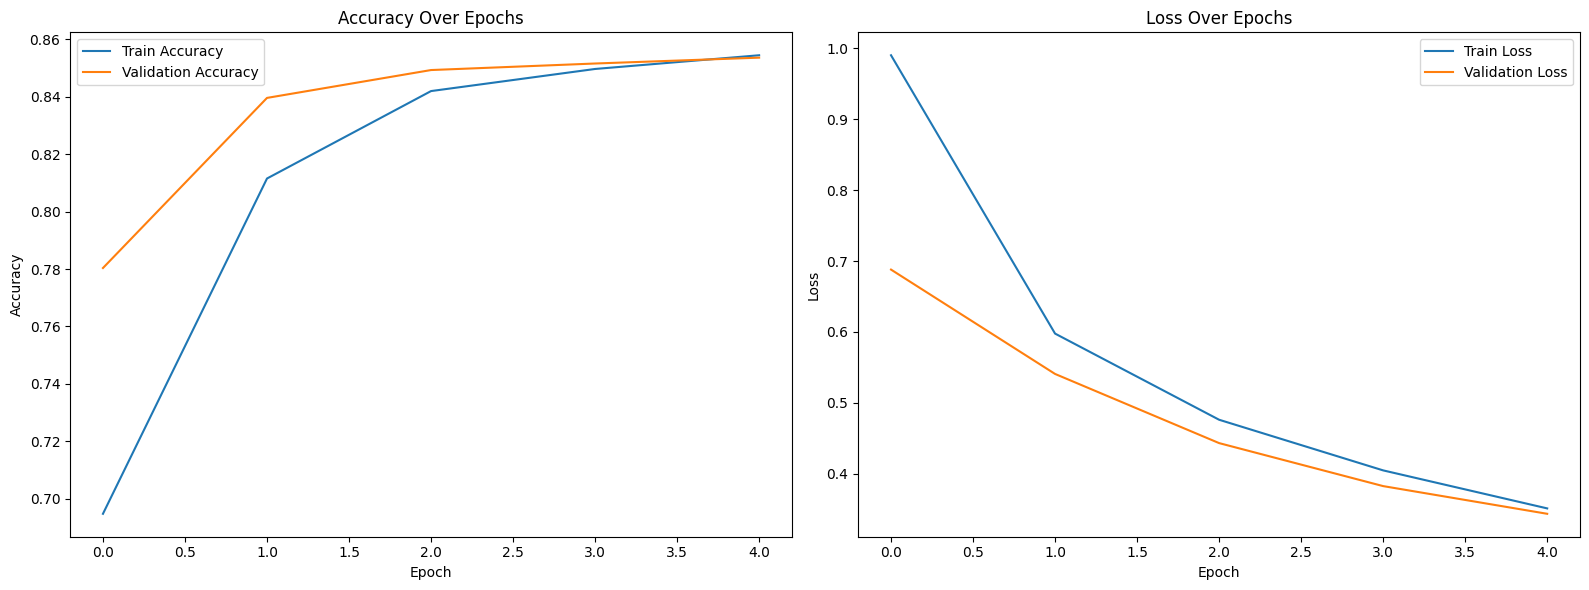

In [11]:
print("\nEvaluating model...")

# === Dự đoán lớp và xác suất ===
y_pred_probs = attn_model.predict(X_test_cnn, verbose=0)
print("Prediction output shape:", y_pred_probs.shape)

# Lấy lớp dự đoán và lớp thật
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)

# === Tính các chỉ số đánh giá ===
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"Recall   : {rec:.4f} ({rec*100:.2f}%)")
print(f"F1-Score : {f1:.4f} ({f1*100:.2f}%)")

# === Confusion Matrix ===
labels = list(encoder.classes_)  # encoder đã dùng khi encode y
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix — CNN+BiLSTM+Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# === Hàm vẽ biểu đồ training history ===
def plot_history(history):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# === Vẽ lịch sử huấn luyện của mô hình Attention ===
plot_history(history_attn)

# === Dọn bộ nhớ Keras ===
tf.keras.backend.clear_session()


In [12]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, BatchNormalization,
                                     SpatialDropout1D, Bidirectional, LSTM,
                                     MultiHeadAttention, Add, LayerNormalization,
                                     GlobalAveragePooling1D, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [13]:
# ========= 2018: giả sử df đã load sẵn từ phần trước =========
# df: dataframe đã được làm sạch từ CSE-CIC-IDS2018
df18 = df.copy()
df18.columns = [c.strip().replace(' ', '_') for c in df18.columns]

# ========= 2017: đọc file balanced 77 features =========
df17 = pd.read_csv('/kaggle/input/cicids2017-balanced-77feats/cicids2017_balanced_77feats.csv')
df17.columns = [c.strip().replace(' ', '_') for c in df17.columns]

print("2018:", df18.shape)
print("2017:", df17.shape)
print("2017 columns sample:", df17.columns[:10])

# ========= Tìm các cột feature chung giữa 2017 và 2018 =========
cols18 = set(df18.columns)
cols17 = set(df17.columns)

# bỏ cột nhãn ra khỏi feature
feature_common = list((cols17 & cols18) - {'Label', 'Label_bin'})
print("Common feature columns:", len(feature_common))
print("Ví dụ 10 cột:", feature_common[:10])

# ========= Tạo bản sao dùng chung =========
df17_common = df17[feature_common + ['Label']].copy()
df18_common = df18[feature_common + ['Label']].copy()

print("df17_common cols:", df17_common.columns.tolist()[:5], "...")
print("df18_common cols:", df18_common.columns.tolist()[:5], "...")


2018: (360000, 79)
2017: (137992, 78)
2017 columns sample: Index(['Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets',
       'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets',
       'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min',
       'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std',
       'Bwd_Packet_Length_Max'],
      dtype='object')
Common feature columns: 27
Ví dụ 10 cột: ['Fwd_IAT_Std', 'Flow_IAT_Std', 'Bwd_PSH_Flags', 'Flow_IAT_Max', 'Bwd_IAT_Min', 'Bwd_IAT_Mean', 'CWE_Flag_Count', 'Idle_Std', 'Flow_Duration', 'Active_Min']
df17_common cols: ['Fwd_IAT_Std', 'Flow_IAT_Std', 'Bwd_PSH_Flags', 'Flow_IAT_Max', 'Bwd_IAT_Min'] ...
df18_common cols: ['Fwd_IAT_Std', 'Flow_IAT_Std', 'Bwd_PSH_Flags', 'Flow_IAT_Max', 'Bwd_IAT_Min'] ...


In [14]:
# ---- 2017: Label đã encode 0..7, 0 = benign ----
df17_common['Label_bin'] = (df17_common['Label'].astype(int) != 0).astype(int)
y17_bin = df17_common['Label_bin'].values

# ---- 2018: Label text 'BENIGN', 'DoS Hulk', ... ----
if df18_common['Label'].dtype == 'O':
    lbl_str = df18_common['Label'].astype(str).str.upper()
    df18_common['Label_bin'] = lbl_str.str.contains('BENIGN').map({True: 0, False: 1}).astype(int)
else:
    df18_common['Label_bin'] = (df18_common['Label'].astype(int) != 0).astype(int)

y18_bin = df18_common['Label_bin'].astype(int).values

# ---- Ma trận feature (float32) ----
X18 = df18_common[feature_common].values.astype(np.float32)
X17 = df17_common[feature_common].values.astype(np.float32)

print("X18:", X18.shape, "y18_bin:", y18_bin.shape)
print("X17:", X17.shape, "y17_bin:", y17_bin.shape)
print("Unique y18_bin:", np.unique(y18_bin, return_counts=True))
print("Unique y17_bin:", np.unique(y17_bin, return_counts=True))


X18: (360000, 27) y18_bin: (360000,)
X17: (137992, 27) y17_bin: (137992,)
Unique y18_bin: (array([0, 1]), array([ 40000, 320000]))
Unique y17_bin: (array([0, 1]), array([ 30000, 107992]))


In [15]:
# ---- 2017: Label đã encode 0..7, 0 = benign ----
df17_common['Label_bin'] = (df17_common['Label'].astype(int) != 0).astype(int)
y17_bin = df17_common['Label_bin'].values

# ---- 2018: Label text 'BENIGN', 'DoS Hulk', ... ----
if df18_common['Label'].dtype == 'O':
    lbl_str = df18_common['Label'].astype(str).str.upper()
    df18_common['Label_bin'] = lbl_str.str.contains('BENIGN').map({True: 0, False: 1}).astype(int)
else:
    df18_common['Label_bin'] = (df18_common['Label'].astype(int) != 0).astype(int)

y18_bin = df18_common['Label_bin'].astype(int).values

# ---- Ma trận feature (float32) ----
X18 = df18_common[feature_common].values.astype(np.float32)
X17 = df17_common[feature_common].values.astype(np.float32)

print("X18:", X18.shape, "y18_bin:", y18_bin.shape)
print("X17:", X17.shape, "y17_bin:", y17_bin.shape)
print("Unique y18_bin:", np.unique(y18_bin, return_counts=True))
print("Unique y17_bin:", np.unique(y17_bin, return_counts=True))


X18: (360000, 27) y18_bin: (360000,)
X17: (137992, 27) y17_bin: (137992,)
Unique y18_bin: (array([0, 1]), array([ 40000, 320000]))
Unique y17_bin: (array([0, 1]), array([ 30000, 107992]))


In [16]:
# ---- Chia train/test cho 2018 ----
X18_tr, X18_te, y18_tr, y18_te = train_test_split(
    X18, y18_bin,
    test_size=0.2,
    stratify=y18_bin,
    random_state=42
)

# ---- Chia train/test cho 2017 (để dùng cho DANN case source=2017) ----
X17_tr, X17_te, y17_tr, y17_te = train_test_split(
    X17, y17_bin,
    test_size=0.2,
    stratify=y17_bin,
    random_state=42
)

print("2018 train:", X18_tr.shape, y18_tr.shape)
print("2018 test :",  X18_te.shape, y18_te.shape)
print("2017 train:", X17_tr.shape, y17_tr.shape)
print("2017 test :",  X17_te.shape, y17_te.shape)

# ---- Fit selector + scaler trên train 2018 (giữ như bạn đang dùng) ----
selector_cd = VarianceThreshold(threshold=0.01).fit(X18_tr)

X18_tr_f = selector_cd.transform(X18_tr)
X18_te_f = selector_cd.transform(X18_te)

X17_tr_f = selector_cd.transform(X17_tr)
X17_te_f = selector_cd.transform(X17_te)
X17_all_f = selector_cd.transform(X17)   # dùng cho target full khi cần

scaler_cd = RobustScaler(quantile_range=(5, 95)).fit(X18_tr_f)

X18_tr_s = scaler_cd.transform(X18_tr_f)
X18_te_s = scaler_cd.transform(X18_te_f)

X17_tr_s = scaler_cd.transform(X17_tr_f)
X17_te_s = scaler_cd.transform(X17_te_f)
X17_all_s = scaler_cd.transform(X17_all_f)

print("After feature selection + scaling:")
print("2018 train:", X18_tr_s.shape)
print("2018 test :", X18_te_s.shape)
print("2017 train:", X17_tr_s.shape)
print("2017 test :", X17_te_s.shape)
print("2017 all  :", X17_all_s.shape)


2018 train: (288000, 27) (288000,)
2018 test : (72000, 27) (72000,)
2017 train: (110393, 27) (110393,)
2017 test : (27599, 27) (27599,)
After feature selection + scaling:
2018 train: (288000, 23)
2018 test : (72000, 23)
2017 train: (110393, 23)
2017 test : (27599, 23)
2017 all  : (137992, 23)


In [17]:
class GradientReversal(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_ = lambda_

    def call(self, x):
        lambda_ = self.lambda_

        @tf.custom_gradient
        def _reverse(x):
            def grad(dy):
                return -lambda_ * dy
            return x, grad

        return _reverse(x)

def build_dann_model(timesteps, channels, lambda_d=1.0, lr=1e-4):
    inp = Input(shape=(timesteps, channels), name="inputs_dann")

    x = Conv1D(128, 3, padding='same', activation='relu',
               kernel_regularizer=l2(1e-4))(inp)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.2)(x)
    x = MaxPooling1D(2, padding='same')(x)

    x = Conv1D(256, 3, padding='same', activation='relu',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.2)(x)
    x = MaxPooling1D(2, padding='same')(x)

    x = Bidirectional(LSTM(128, return_sequences=True),
                      name="bilstm_dann")(x)

    attn_out = MultiHeadAttention(num_heads=4, key_dim=64,
                                  name="mha_dann")(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    features = GlobalAveragePooling1D(name="gap_dann")(x)

    # ----- Classification head -----
    h_cls = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(features)
    h_cls = Dropout(0.4)(h_cls)
    out_cls = Dense(2, activation='softmax', name="cls_output")(h_cls)

    # ----- Domain head + GRL -----
    grl = GradientReversal(lambda_=lambda_d, name="grad_reverse")(features)
    h_dom = Dense(64, activation='relu')(grl)
    out_dom = Dense(2, activation='softmax', name="dom_output")(h_dom)

    model = Model(inputs=inp, outputs=[out_cls, out_dom], name="DANN_IDS")

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            "cls_output": "categorical_crossentropy",
            "dom_output": "categorical_crossentropy",
        },
        loss_weights={"cls_output": 1.0, "dom_output": 0.5},
        metrics={"cls_output": ["accuracy"], "dom_output": ["accuracy"]}
    )
    return model


In [18]:
def eval_binary(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1


In [20]:
# Thêm channel cho CNN (N, T, 1)
X18_tr_cnn   = X18_tr_s[..., np.newaxis]
X18_te_cnn   = X18_te_s[..., np.newaxis]

X17_tr_cnn   = X17_tr_s[..., np.newaxis]
X17_te_cnn   = X17_te_s[..., np.newaxis]
X17_all_cnn  = X17_all_s[..., np.newaxis]   # full 2017

# 2018 all (train + test) – thuận tiện cho DANN case source=2017
X18_all_s    = scaler_cd.transform(selector_cd.transform(X18))
X18_all_cnn  = X18_all_s[..., np.newaxis]

# One-hot labels
y18_tr_oh = to_categorical(y18_tr, num_classes=2)
y18_te_oh = to_categorical(y18_te, num_classes=2)
y18_all_oh = to_categorical(y18_bin, num_classes=2)

y17_tr_oh = to_categorical(y17_tr, num_classes=2)
y17_te_oh = to_categorical(y17_te, num_classes=2)
y17_all_oh = to_categorical(y17_bin, num_classes=2)

print("Created CNN tensors successfully:")
print("X18_tr_cnn:", X18_tr_cnn.shape)
print("X17_all_cnn:", X17_all_cnn.shape)


Created CNN tensors successfully:
X18_tr_cnn: (288000, 23, 1)
X17_all_cnn: (137992, 23, 1)


In [21]:
timesteps = X18_tr_cnn.shape[1]
channels  = X18_tr_cnn.shape[2]

# ----- Gộp dữ liệu cho DANN: source=2018 train, target=2017 full -----
X_s_18 = X18_tr_cnn
y_s_18 = y18_tr_oh

X_t_17 = X17_all_cnn
y_t_17 = y17_all_oh   # dùng supervised DANN

Ns = X_s_18.shape[0]
Nt = X_t_17.shape[0]

X_all_18src = np.concatenate([X_s_18, X_t_17], axis=0)
y_cls_all_18src = np.concatenate([y_s_18, y_t_17], axis=0)

dom_s = np.zeros(Ns, dtype=int)
dom_t = np.ones(Nt, dtype=int)
y_dom_all_18src = to_categorical(np.concatenate([dom_s, dom_t]), 2)

print("X_all (18→17):", X_all_18src.shape)

# ----- Train DANN (source=2018) -----
dann_18src = build_dann_model(timesteps, channels, lambda_d=1.0, lr=1e-4)

callbacks_dann = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_cls_output_loss",
        mode="min",
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_cls_output_loss",
        mode="min",
        factor=0.3,
        patience=2,
        min_lr=1e-6
    ),
]

history_18src = dann_18src.fit(
    X_all_18src,
    {"cls_output": y_cls_all_18src, "dom_output": y_dom_all_18src},
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks_dann,
    verbose=1
)

# ----- Evaluate: 2018 test (in-domain) -----
y18_prob_18src, _ = dann_18src.predict(X18_te_cnn, verbose=0)
y18_pred_18src = np.argmax(y18_prob_18src, axis=1)
metrics_18_in = eval_binary(y18_te, y18_pred_18src)

# ----- Evaluate: 2017 all (cross-domain) -----
y17_prob_18src, _ = dann_18src.predict(X17_all_cnn, verbose=0)
y17_pred_18src = np.argmax(y17_prob_18src, axis=1)
metrics_17_cross_from18 = eval_binary(y17_bin, y17_pred_18src)

print("DANN source=2018 → test 2018 (in-domain):", metrics_18_in)
print("DANN source=2018 → test 2017 (cross):    ", metrics_17_cross_from18)


X_all (18→17): (425992, 23, 1)
Epoch 1/20
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - cls_output_accuracy: 0.8030 - cls_output_loss: 0.5217 - dom_output_accuracy: 0.1595 - dom_output_loss: 6.1870 - loss: 3.6489 - val_cls_output_accuracy: 0.9997 - val_cls_output_loss: 0.1970 - val_dom_output_accuracy: 0.6320 - val_dom_output_loss: 0.6216 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 2/20
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - cls_output_accuracy: 0.8219 - cls_output_loss: 0.4646 - dom_output_accuracy: 0.6541 - dom_output_loss: 0.9138 - loss: 0.9531 - val_cls_output_accuracy: 0.9714 - val_cls_output_loss: 0.2223 - val_dom_output_accuracy: 0.0000e+00 - val_dom_output_loss: 3.4897 - val_loss: 1.9967 - learning_rate: 1.0000e-04
Epoch 3/20
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - cls_output_accuracy: 0.8358 - cls_output_loss: 0.4204 - dom_output_accuracy: 0.7086 - dom_output_loss: 0.7626 - loss: 0.8313 - val_cls_output_accuracy: 0.9842 - val_cls_output_loss: 0.1943 - 

In [22]:
# ----- Gộp dữ liệu cho DANN: source=2017 train, target=2018 all -----
X_s_17 = X17_tr_cnn
y_s_17 = y17_tr_oh

X_t_18 = X18_all_cnn
y_t_18 = y18_all_oh

Ns = X_s_17.shape[0]
Nt = X_t_18.shape[0]

X_all_17src = np.concatenate([X_s_17, X_t_18], axis=0)
y_cls_all_17src = np.concatenate([y_s_17, y_t_18], axis=0)

dom_s = np.zeros(Ns, dtype=int)
dom_t = np.ones(Nt, dtype=int)
y_dom_all_17src = to_categorical(np.concatenate([dom_s, dom_t]), 2)

print("X_all (17→18):", X_all_17src.shape)

# ----- Train DANN (source=2017) -----
dann_17src = build_dann_model(timesteps, channels, lambda_d=1.0, lr=1e-4)

history_17src = dann_17src.fit(
    X_all_17src,
    {"cls_output": y_cls_all_17src, "dom_output": y_dom_all_17src},
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks_dann,
    verbose=1
)

# ----- Evaluate: 2017 test (in-domain) -----
y17_prob_17src, _ = dann_17src.predict(X17_te_cnn, verbose=0)
y17_pred_17src = np.argmax(y17_prob_17src, axis=1)
metrics_17_in = eval_binary(y17_te, y17_pred_17src)

# ----- Evaluate: 2018 test (cross-domain) -----
y18_prob_17src, _ = dann_17src.predict(X18_te_cnn, verbose=0)
y18_pred_17src = np.argmax(y18_prob_17src, axis=1)
metrics_18_cross_from17 = eval_binary(y18_te, y18_pred_17src)

print("DANN source=2017 → test 2017 (in-domain):", metrics_17_in)
print("DANN source=2017 → test 2018 (cross):    ", metrics_18_cross_from17)


X_all (17→18): (470393, 23, 1)
Epoch 1/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - cls_output_accuracy: 0.8142 - cls_output_loss: 0.4980 - dom_output_accuracy: 0.3133 - dom_output_loss: 4.7458 - loss: 2.9046 - val_cls_output_accuracy: 0.9806 - val_cls_output_loss: 0.2128 - val_dom_output_accuracy: 0.7796 - val_dom_output_loss: 0.7723 - val_loss: 0.6312 - learning_rate: 1.0000e-04
Epoch 2/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - cls_output_accuracy: 0.8360 - cls_output_loss: 0.4550 - dom_output_accuracy: 0.4995 - dom_output_loss: 2.0057 - loss: 1.4895 - val_cls_output_accuracy: 0.9655 - val_cls_output_loss: 0.2882 - val_dom_output_accuracy: 0.8183 - val_dom_output_loss: 0.1981 - val_loss: 0.4172 - learning_rate: 1.0000e-04
Epoch 3/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - cls_output_accuracy: 0.8440 - cls_output_loss: 0.4164 - dom_output_accuracy: 0.5210 - dom_output_loss: 0.9718 - loss: 0.9314 - val_cls_output_accuracy: 0.8300 - val_cls_output_loss: 0.5601 - val_

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# ====== LOAD CSE-CIC-IDS2018 (file 40k cleaned) ======
df18 = pd.read_csv(
    "/kaggle/input/cse-cic-ids2018-cleaned-40k-samples-each/cleaned_data_sampled.csv"
    # ↑ SỬA đường dẫn + tên file cho đúng với dataset của bạn
)
df18.columns = [c.strip().replace(" ", "_") for c in df18.columns]

print("2018 raw:", df18.shape)
print(df18[["Label"]].head())

# ====== LOAD CIC-IDS2017 balanced 77 features ======
df17 = pd.read_csv(
    "/kaggle/input/cicids2017-balanced-77feats/cicids2017_balanced_77feats.csv"
)
df17.columns = [c.strip().replace(" ", "_") for c in df17.columns]

print("2017 raw:", df17.shape)
print(df17[["Label"]].head())


2018 raw: (360000, 79)
   Label
0      0
1      0
2      0
3      0
4      0
2017 raw: (137992, 78)
   Label
0      0
1      0
2      0
3      0
4      0


In [38]:
# ==== Tìm các cột feature chung ====
cols18 = set(df18.columns)
cols17 = set(df17.columns)

# Bỏ nhãn ra khỏi feature
feature_common = list((cols17 & cols18) - {"Label", "Label_bin"})
print("Common feature columns:", len(feature_common))
print("Ví dụ 10 cột:", feature_common[:10])

# Bản dùng chung
df18_common = df18[feature_common + ["Label"]].copy()
df17_common = df17[feature_common + ["Label"]].copy()

# ==== Label_bin cho 2017 (encoder: 0 = benign) ====
df17_common["Label_bin"] = (df17_common["Label"].astype(int) != 0).astype(int)
y17_bin = df17_common["Label_bin"].values

# ==== Label_bin cho 2018 (Label dạng text: 'BENIGN', 'DoS Hulk', ...) ====
lbl18 = df18_common["Label"].astype(str).str.upper()
df18_common["Label_bin"] = lbl18.str.contains("BENIGN").map({True: 0, False: 1}).astype(int)
y18_bin = df18_common["Label_bin"].values

# Ma trận feature
X18 = df18_common[feature_common].values.astype(np.float32)
X17 = df17_common[feature_common].values.astype(np.float32)

print("2018 X:", X18.shape, "y:", y18_bin.shape, "unique:", np.unique(y18_bin, return_counts=True))
print("2017 X:", X17.shape, "y:", y17_bin.shape, "unique:", np.unique(y17_bin, return_counts=True))


Common feature columns: 27
Ví dụ 10 cột: ['Fwd_IAT_Std', 'Flow_IAT_Std', 'Bwd_PSH_Flags', 'Flow_IAT_Max', 'Bwd_IAT_Min', 'Bwd_IAT_Mean', 'CWE_Flag_Count', 'Idle_Std', 'Flow_Duration', 'Active_Min']
2018 X: (360000, 27) y: (360000,) unique: (array([1]), array([360000]))
2017 X: (137992, 27) y: (137992,) unique: (array([0, 1]), array([ 30000, 107992]))


In [39]:
# ==== Tách 2018 train / test ====
X18_tr, X18_te, y18_tr, y18_te = train_test_split(
    X18, y18_bin,
    test_size=0.2,
    stratify=y18_bin,
    random_state=42
)

print("2018 train:", X18_tr.shape, y18_tr.shape)
print("2018 test :", X18_te.shape, y18_te.shape)
print("2017 all :",  X17.shape,    y17_bin.shape)
print("unique y18_tr:", np.unique(y18_tr, return_counts=True))
print("unique y18_te:", np.unique(y18_te, return_counts=True))

# ==== Feature selection + scaling dựa trên 2018 train ====
selector = VarianceThreshold(threshold=0.01).fit(X18_tr)

X18_tr_f = selector.transform(X18_tr)
X18_te_f = selector.transform(X18_te)
X17_f    = selector.transform(X17)

scaler = RobustScaler(quantile_range=(5, 95)).fit(X18_tr_f)
X18_tr_s = scaler.transform(X18_tr_f)
X18_te_s = scaler.transform(X18_te_f)
X17_s    = scaler.transform(X17_f)

print("After FS + scaling:")
print("2018 train:", X18_tr_s.shape)
print("2018 test :", X18_te_s.shape)
print("2017 all  :", X17_s.shape)


2018 train: (288000, 27) (288000,)
2018 test : (72000, 27) (72000,)
2017 all : (137992, 27) (137992,)
unique y18_tr: (array([1]), array([288000]))
unique y18_te: (array([1]), array([72000]))
After FS + scaling:
2018 train: (288000, 23)
2018 test : (72000, 23)
2017 all  : (137992, 23)


In [44]:
import numpy as np

# df18_common, df17_common đã có sẵn

# --- 2017: giữ như cũ ---
df17_common["Label_bin"] = (df17_common["Label"].astype(int) != 0).astype(int)
y17_bin = df17_common["Label_bin"].values

# --- 2018: xử lý cẩn thận hơn ---
lbl18 = df18_common["Label"]

if lbl18.dtype == "O":
    # ép về string
    lbl_str = lbl18.astype(str).str.upper()
    uniques = lbl_str.unique()

    if any("BENIGN" in u for u in uniques):
        # Trường hợp label dạng text: BENIGN, DoS Hulk, ...
        df18_common["Label_bin"] = (~lbl_str.str.contains("BENIGN")).astype(int)
    else:
        # Trường hợp label là số nhưng lưu dạng chuỗi "0","1","2",...
        df18_common["Label_bin"] = (lbl_str.astype(int) != 0).astype(int)
else:
    # Trường hợp label là số int 0,1,2,...
    df18_common["Label_bin"] = (lbl18.astype(int) != 0).astype(int)

y18_bin = df18_common["Label_bin"].astype(int).values

print("unique y18_bin:", np.unique(y18_bin, return_counts=True))
print("unique y17_bin:", np.unique(y17_bin, return_counts=True))


unique y18_bin: (array([0, 1]), array([ 40000, 320000]))
unique y17_bin: (array([0, 1]), array([ 30000, 107992]))


In [45]:
from sklearn.model_selection import train_test_split

X18_tr, X18_te, y18_tr, y18_te = train_test_split(
    X18, y18_bin,
    test_size=0.2,
    stratify=y18_bin,
    random_state=42
)

print("2018 train:", X18_tr.shape, np.unique(y18_tr, return_counts=True))
print("2018 test :", X18_te.shape, np.unique(y18_te, return_counts=True))
print("2017 all :",  X17_s.shape, np.unique(y17_bin, return_counts=True))


2018 train: (288000, 27) (array([0, 1]), array([ 32000, 256000]))
2018 test : (72000, 27) (array([0, 1]), array([ 8000, 64000]))
2017 all : (137992, 23) (array([0, 1]), array([ 30000, 107992]))


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

models_ml = {
    "LogReg": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
}

def eval_ml(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return [
        accuracy_score(y_test, pred),
        precision_score(y_test, pred),
        recall_score(y_test, pred),
        f1_score(y_test, pred)
    ]

results = []

# Case 1: 2018→2018
for name, model in models_ml.items():
    acc, prec, rec, f1 = eval_ml(model, X18_tr_s, y18_tr, X18_te_s, y18_te)
    results.append([name, "2018→2018", acc, prec, rec, f1])

# Case 2: 2018→2017
for name, model in models_ml.items():
    acc, prec, rec, f1 = eval_ml(model, X18_tr_s, y18_tr, X17_s, y17_bin)
    results.append([name, "2018→2017", acc, prec, rec, f1])

# Tách 2017 train/test
X17_tr, X17_te, y17_tr, y17_te = train_test_split(
    X17_s, y17_bin,
    test_size=0.2,
    stratify=y17_bin,
    random_state=42
)

# Case 3: 2017→2017
for name, model in models_ml.items():
    acc, prec, rec, f1 = eval_ml(model, X17_tr, y17_tr, X17_te, y17_te)
    results.append([name, "2017→2017", acc, prec, rec, f1])

# Case 4: 2017→2018
for name, model in models_ml.items():
    acc, prec, rec, f1 = eval_ml(model, X17_tr, y17_tr, X18_te_s, y18_te)
    results.append([name, "2017→2018", acc, prec, rec, f1])

df_ml_results = pd.DataFrame(
    results,
    columns=["Model", "Train→Test", "Accuracy", "Precision", "Recall", "F1"]
)
df_ml_results


,Model,Train→Test,Accuracy,Precision,Recall,F1
0,LogReg,2018→2018,0.888681,0.888887,0.999734,0.941058
1,RandomForest,2018→2018,0.875625,0.889027,0.982750,0.933542
2,LogReg,2018→2017,0.783379,0.783238,0.999935,0.878420
3,RandomForest,2018→2017,0.783502,0.786338,0.993240,0.877761
4,LogReg,2017→2017,0.796985,0.797368,0.992916,0.884462
5,RandomForest,2017→2017,0.962752,0.958744,0.995231,0.976647
6,LogReg,2017→2018,0.879014,0.888981,0.987172,0.935507
7,RandomForest,2017→2018,0.522750,0.888930,0.529219,0.663454


In [51]:
import pandas as pd
import numpy as np

# ===== LOAD DATA =====
df18 = pd.read_csv("/kaggle/input/cse-cic-ids2018-cleaned-40k-samples-each/cleaned_data_sampled.csv")
df17 = pd.read_csv("/kaggle/input/cicids2017-balanced-77feats/cicids2017_balanced_77feats.csv")

df18.columns = [c.strip().replace(" ", "_") for c in df18.columns]
df17.columns = [c.strip().replace(" ", "_") for c in df17.columns]

print("2018:", df18.shape)
print("2017:", df17.shape)

# ===== TÌM CỘT CHUNG =====
cols18 = set(df18.columns)
cols17 = set(df17.columns)
feature_common = list((cols17 & cols18) - {"Label", "Label_bin"})
print("Common features:", len(feature_common))

# ===== TÁCH FEATURES & LABEL =====
df17c = df17[feature_common + ["Label"]].copy()
df18c = df18[feature_common + ["Label"]].copy()

# --- 2017: Label đã là số 0..7, 0 = benign ---
df17c["Label_bin"] = (df17c["Label"].astype(int) != 0).astype(int)

# --- 2018: tuỳ kiểu dữ liệu của Label ---
lbl18 = df18c["Label"]

if lbl18.dtype == "O":
    # Label dạng chuỗi: 'BENIGN', 'DoS Hulk', ...
    df18c["Label_bin"] = (
        ~lbl18.astype(str).str.upper().str.contains("BENIGN")
    ).astype(int)
else:
    # Label dạng số: giả định 0 = benign, !=0 = attack
    df18c["Label_bin"] = (lbl18.astype(int) != 0).astype(int)

# ===== LẤY X, y =====
y17_bin = df17c["Label_bin"].values
y18_bin = df18c["Label_bin"].values

X17 = df17c[feature_common].values.astype(np.float32)
X18 = df18c[feature_common].values.astype(np.float32)

print("X17:", X17.shape, "y17:", np.unique(y17_bin, return_counts=True))
print("X18:", X18.shape, "y18:", np.unique(y18_bin, return_counts=True))


2018: (360000, 79)
2017: (137992, 78)
Common features: 27
X17: (137992, 27) y17: (array([0, 1]), array([ 30000, 107992]))
X18: (360000, 27) y18: (array([0, 1]), array([ 40000, 320000]))


In [52]:
# ===== CELL 2: Train/test split + feature selection + scaling + reshape CNN =====
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.utils import to_categorical
import numpy as np

# 1) Chia 2018 thành train / test (in-domain 2018)
X18_tr, X18_te, y18_tr, y18_te = train_test_split(
    X18, y18_bin,
    test_size=0.2,
    stratify=y18_bin,
    random_state=42
)

print("2018 train:", X18_tr.shape, y18_tr.shape)
print("2018 test :", X18_te.shape, y18_te.shape)
print("2017 all  :", X17.shape,    y17_bin.shape)

print("unique y18_tr:", np.unique(y18_tr, return_counts=True))
print("unique y18_te:", np.unique(y18_te, return_counts=True))
print("unique y17_bin:", np.unique(y17_bin, return_counts=True))

# 2) Feature selection (VarianceThreshold) + scaling (RobustScaler)
selector_cd = VarianceThreshold(threshold=0.01).fit(X18_tr)

X18_tr_f = selector_cd.transform(X18_tr)
X18_te_f = selector_cd.transform(X18_te)
X17_f    = selector_cd.transform(X17)

scaler_cd = RobustScaler(quantile_range=(5, 95)).fit(X18_tr_f)

X18_tr_s = scaler_cd.transform(X18_tr_f)
X18_te_s = scaler_cd.transform(X18_te_f)
X17_s    = scaler_cd.transform(X17_f)

print("\nAfter feature selection + scaling:")
print("2018 train:", X18_tr_s.shape)
print("2018 test :", X18_te_s.shape)
print("2017 all  :", X17_s.shape)

# 3) Thêm channel cho CNN: (N, T, 1)
X18_tr_cnn = X18_tr_s[..., np.newaxis]
X18_te_cnn = X18_te_s[..., np.newaxis]
X17_cnn    = X17_s[..., np.newaxis]

# 4) One-hot nhãn (binary 0/1 → num_classes=2)
y18_tr_oh = to_categorical(y18_tr, num_classes=2)
y18_te_oh = to_categorical(y18_te, num_classes=2)
y17_oh    = to_categorical(y17_bin, num_classes=2)

print("\nShapes for CNN:")
print("2018 train:", X18_tr_cnn.shape, y18_tr_oh.shape)
print("2018 test :", X18_te_cnn.shape, y18_te_oh.shape)
print("2017 all  :", X17_cnn.shape,    y17_oh.shape)


2018 train: (288000, 27) (288000,)
2018 test : (72000, 27) (72000,)
2017 all  : (137992, 27) (137992,)
unique y18_tr: (array([0, 1]), array([ 32000, 256000]))
unique y18_te: (array([0, 1]), array([ 8000, 64000]))
unique y17_bin: (array([0, 1]), array([ 30000, 107992]))

After feature selection + scaling:
2018 train: (288000, 23)
2018 test : (72000, 23)
2017 all  : (137992, 23)

Shapes for CNN:
2018 train: (288000, 23, 1) (288000, 2)
2018 test : (72000, 23, 1) (72000, 2)
2017 all  : (137992, 23, 1) (137992, 2)


In [54]:
# ===== CELL 3: Baseline CNN–BiLSTM–Attention + evaluate =====
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, BatchNormalization,
                                     SpatialDropout1D, Bidirectional, LSTM,
                                     MultiHeadAttention, Add, LayerNormalization,
                                     GlobalAveragePooling1D, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

timesteps = X18_tr_cnn.shape[1]
channels  = X18_tr_cnn.shape[2]

def build_baseline_model(timesteps, channels, lr=1e-3):
    """Hybrid CNN–BiLSTM–Attention cho bài toán nhị phân."""
    inp = Input(shape=(timesteps, channels), name="inputs")

    x = Conv1D(128, 3, padding='same', activation='relu',
               kernel_regularizer=l2(1e-4))(inp)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.2)(x)
    x = MaxPooling1D(2, padding='same')(x)

    x = Conv1D(256, 3, padding='same', activation='relu',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.2)(x)
    x = MaxPooling1D(2, padding='same')(x)

    x = Bidirectional(LSTM(128, return_sequences=True),
                      name="bilstm")(x)

    attn_out = MultiHeadAttention(num_heads=4, key_dim=64,
                                  name="mha")(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D(name="gap")(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    out = Dense(2, activation='softmax', name="cls_output")(x)

    model = Model(inputs=inp, outputs=out, name="Baseline_IDS")
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


def train_and_eval_baseline(X_train, y_train_oh, 
                            X_test,  y_test_bin,
                            lr=1e-3, batch_size=256, epochs=20):
    """Train 1 lần baseline và trả về (acc, prec, rec, f1) trên tập test_bin."""
    model = build_baseline_model(timesteps, channels, lr=lr)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=4,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            factor=0.3,
            patience=2,
            min_lr=1e-6
        )
    ]

    model.fit(
        X_train, y_train_oh,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )

    # Dự đoán trên test
    y_prob = model.predict(X_test, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    acc  = accuracy_score(y_test_bin, y_pred)
    prec = precision_score(y_test_bin, y_pred)
    rec  = recall_score(y_test_bin, y_pred)
    f1   = f1_score(y_test_bin, y_pred)

    return acc, prec, rec, f1


In [55]:
# ===== CELL 4: Tách 2017 thành train / test cho in-domain =====
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X17_tr_cnn, X17_te_cnn, y17_tr, y17_te = train_test_split(
    X17_cnn, y17_bin,
    test_size=0.2,
    stratify=y17_bin,
    random_state=42
)

y17_tr_oh = to_categorical(y17_tr, num_classes=2)
y17_te_oh = to_categorical(y17_te, num_classes=2)

print("2017 train:", X17_tr_cnn.shape, y17_tr_oh.shape)
print("2017 test :", X17_te_cnn.shape, y17_te_oh.shape)


2017 train: (110393, 23, 1) (110393, 2)
2017 test : (27599, 23, 1) (27599, 2)


In [56]:
# ===== CELL 5: 4 kịch bản baseline CNN–BiLSTM–Attention =====
import pandas as pd

baseline_results = []

# Case 1: Train 2018 → Test 2018 (in-domain 2018)
metrics_18_in = train_and_eval_baseline(
    X_train   = X18_tr_cnn,
    y_train_oh= y18_tr_oh,
    X_test    = X18_te_cnn,
    y_test_bin= y18_te
)
baseline_results.append(["Baseline", "2018→2018", *metrics_18_in])

# Case 2: Train 2018 → Test 2017 (cross-domain)
metrics_18_to_17 = train_and_eval_baseline(
    X_train   = X18_tr_cnn,
    y_train_oh= y18_tr_oh,
    X_test    = X17_cnn,
    y_test_bin= y17_bin
)
baseline_results.append(["Baseline", "2018→2017", *metrics_18_to_17])

# Case 3: Train 2017 → Test 2017 (in-domain 2017)
metrics_17_in = train_and_eval_baseline(
    X_train   = X17_tr_cnn,
    y_train_oh= y17_tr_oh,
    X_test    = X17_te_cnn,
    y_test_bin= y17_te
)
baseline_results.append(["Baseline", "2017→2017", *metrics_17_in])

# Case 4: Train 2017 → Test 2018 (cross-domain)
metrics_17_to_18 = train_and_eval_baseline(
    X_train   = X17_tr_cnn,
    y_train_oh= y17_tr_oh,
    X_test    = X18_te_cnn,
    y_test_bin= y18_te
)
baseline_results.append(["Baseline", "2017→2018", *metrics_17_to_18])

df_baseline = pd.DataFrame(
    baseline_results,
    columns=["Model", "Train→Test", "Accuracy", "Precision", "Recall", "F1"]
)

df_baseline


Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8869 - loss: 0.3601 - val_accuracy: 0.8831 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9067 - loss: 0.2560 - val_accuracy: 0.9065 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9110 - loss: 0.2089 - val_accuracy: 0.9118 - val_loss: 0.1969 - learning_rate: 0.0010
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9124 - loss: 0.1993 - val_accuracy: 0.9132 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9137 - loss: 0.1925 - val_accuracy: 0.9113 - val_loss: 0.2277 - learning_rate: 0.0010
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9158 - loss: 0.1873 - val_accuracy: 0.9141 - val_loss: 0.1821 - learning_rate: 0.0010
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9157 - l

,Model,Train→Test,Accuracy,Precision,Recall,F1
0,Baseline,2018→2018,0.923708,0.938879,0.977828,0.957958
1,Baseline,2018→2017,0.777733,0.820831,0.915910,0.865768
2,Baseline,2017→2017,0.943295,0.936623,0.994861,0.964864
3,Baseline,2017→2018,0.597806,0.941869,0.583547,0.720623
